In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from collections import Counter

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Class distribution: Counter({0: 583, 1: 291})


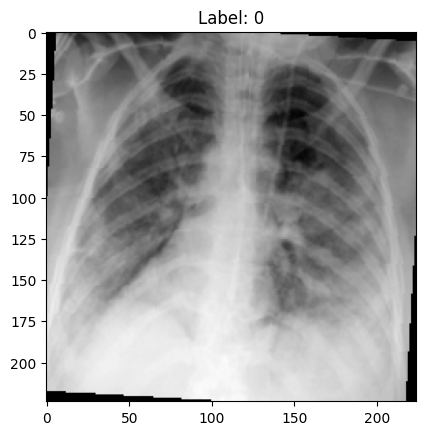

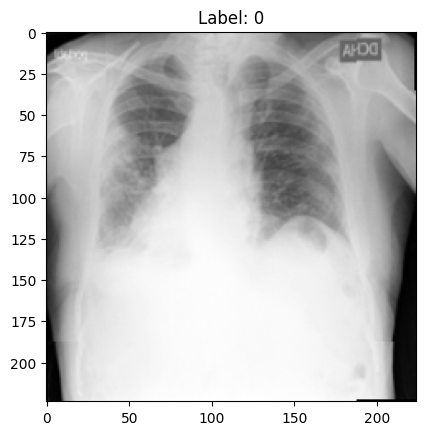

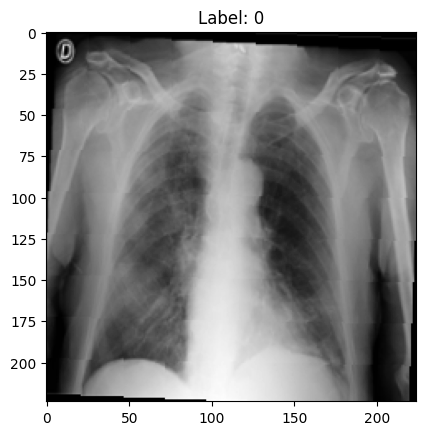

In [15]:
# Define transformations with data augmentation (Highlighted Change 1)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset and verify class distribution (Highlighted Change 2)
train_dataset = datasets.ImageFolder(
    root=r'C:\Users\sarva\Desktop\nf\code\edochetta\test',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Check dataset balance
labels = [label for _, label in train_dataset]
print(f"Class distribution: {Counter(labels)}")

# Visualize some images and labels
for i in range(3):
    img, label = train_dataset[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()



In [16]:
# Define the model with BCEWithLogitsLoss compatibility (Highlighted Change 3)
class CovidNet(nn.Module):
    def __init__(self):
        super(CovidNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 26 * 26, 64)
        self.fc2 = nn.Linear(64, 1)  # Raw output for BCEWithLogitsLoss

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No Sigmoid here
        return x




In [18]:
# Initialize the model, loss function, and optimizer
model = CovidNet().to(device)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss (Highlighted Change 4)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer (Highlighted Change 5)

# Start training with accuracy tracking
print('Starting training...')
num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()  # Ensure labels are in the correct shape

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply Sigmoid here for prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 10 == 0:  # Print loss every 10 batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / (i + 1):.4f}')

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1} completed with Accuracy: {accuracy:.2f}%')

print('Finished Training')


Starting training...
[Epoch 1, Batch 1] Loss: 0.7022
[Epoch 1, Batch 11] Loss: 0.7073
[Epoch 1, Batch 21] Loss: 0.6529
Epoch 1 completed with Accuracy: 71.05%
[Epoch 2, Batch 1] Loss: 0.4594
[Epoch 2, Batch 11] Loss: 0.4472
[Epoch 2, Batch 21] Loss: 0.4583
Epoch 2 completed with Accuracy: 81.35%
[Epoch 3, Batch 1] Loss: 0.4927
[Epoch 3, Batch 11] Loss: 0.4453
[Epoch 3, Batch 21] Loss: 0.4370
Epoch 3 completed with Accuracy: 81.35%
[Epoch 4, Batch 1] Loss: 0.5223
[Epoch 4, Batch 11] Loss: 0.3837
[Epoch 4, Batch 21] Loss: 0.3672
Epoch 4 completed with Accuracy: 83.64%
[Epoch 5, Batch 1] Loss: 0.2779
[Epoch 5, Batch 11] Loss: 0.3293
[Epoch 5, Batch 21] Loss: 0.3527
Epoch 5 completed with Accuracy: 83.75%
[Epoch 6, Batch 1] Loss: 0.3023
[Epoch 6, Batch 11] Loss: 0.3095
[Epoch 6, Batch 21] Loss: 0.3258
Epoch 6 completed with Accuracy: 86.38%
[Epoch 7, Batch 1] Loss: 0.3989
[Epoch 7, Batch 11] Loss: 0.3869
[Epoch 7, Batch 21] Loss: 0.3390
Epoch 7 completed with Accuracy: 85.70%
[Epoch 8, Bat

In [20]:
# Save the trained model
model_path = r"C:\Users\sarva\Desktop\nf\code\edochetta\ilu.pth"  # Specify the path and filename
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to C:\Users\sarva\Desktop\nf\code\edochetta\ilu.pth
